In [46]:
import datetime
import os


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

In [47]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('val_images.tfrecords')

In [48]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [49]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [50]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [8]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [9]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [10]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [11]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

In [12]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

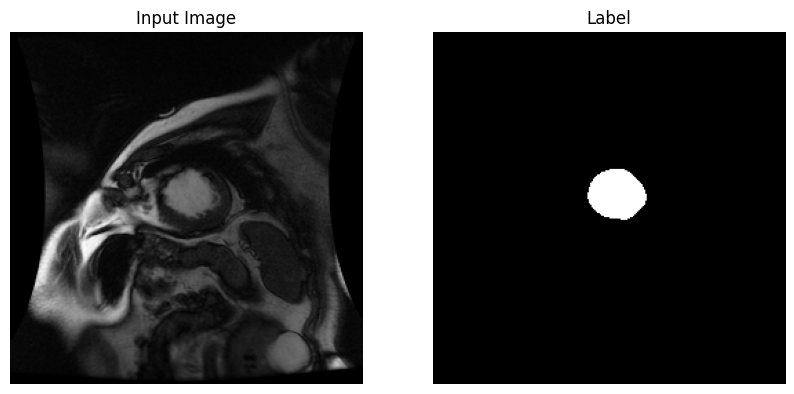

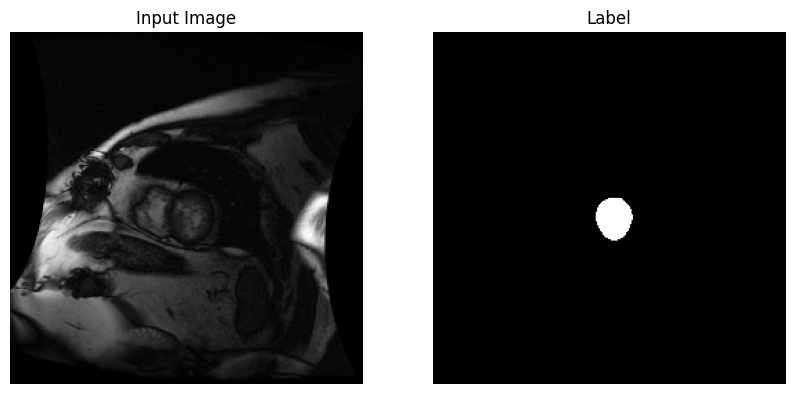

In [13]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

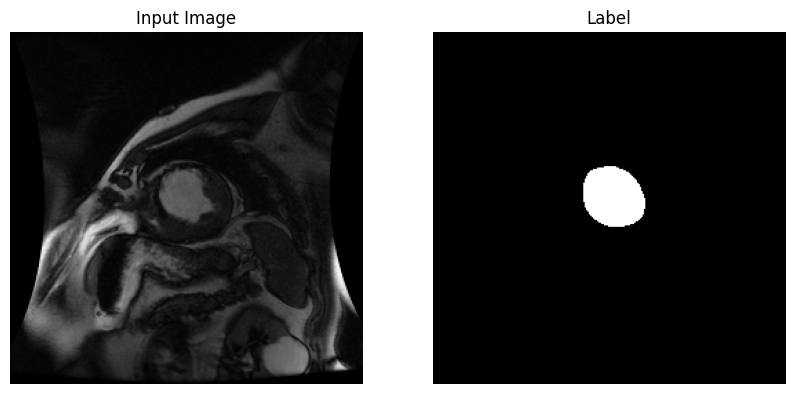

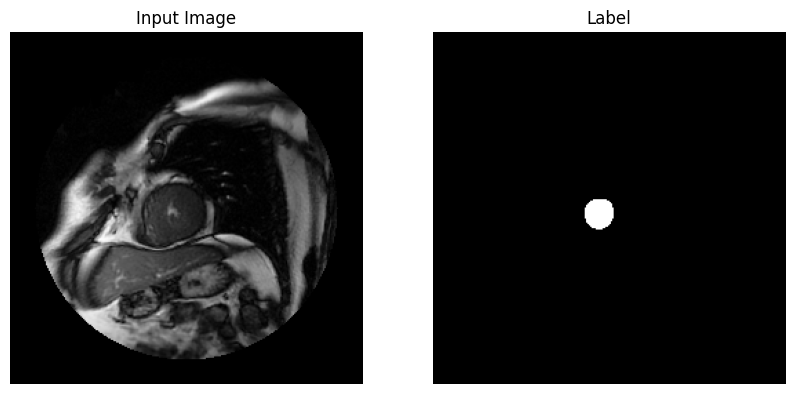

In [14]:
# display an image and label from the test set
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

In [15]:
tf.keras.backend.clear_session()

# set up the model architecture
model = tf.keras.models.Sequential([
    Flatten(input_shape=[256, 256, 1]),
    Dense(64, activation='relu'),
    Dense(256*256*2, activation='softmax'),
    Reshape((256, 256, 2))
])

# specify how to train the model with algorithm, the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

C:\Users\p\PycharmProjects\Image Segementation\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# print out the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │     8,519,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 256, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,714,048 (48.50 MB)

 Trainable params: 12,714,048 (48.50 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [18]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [19]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


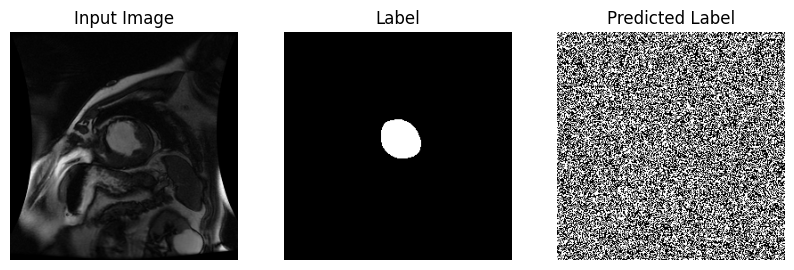

In [20]:
# show a predection, as an example
show_predictions(test_dataset)

In [21]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/steps


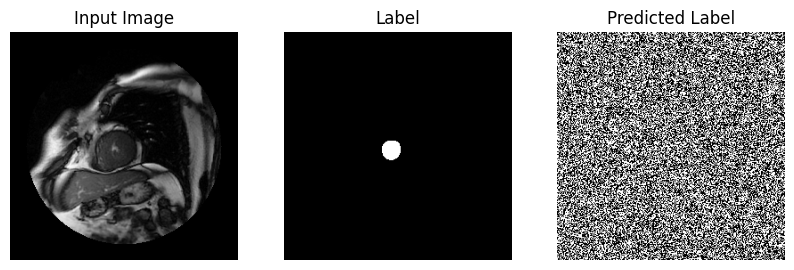


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.5039 - loss: 0.6931 - val_accuracy: 0.5101 - val_loss: 0.6931
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/steps


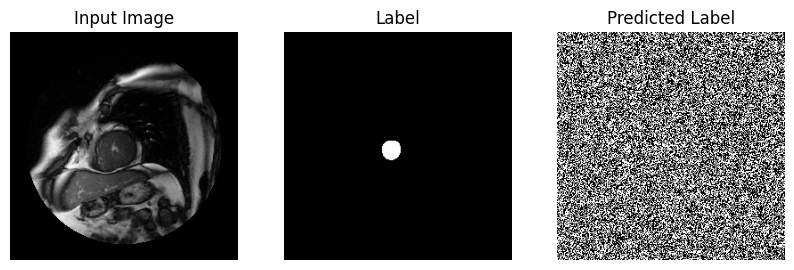


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.5179 - loss: 0.6931 - val_accuracy: 0.5265 - val_loss: 0.6931
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/steps


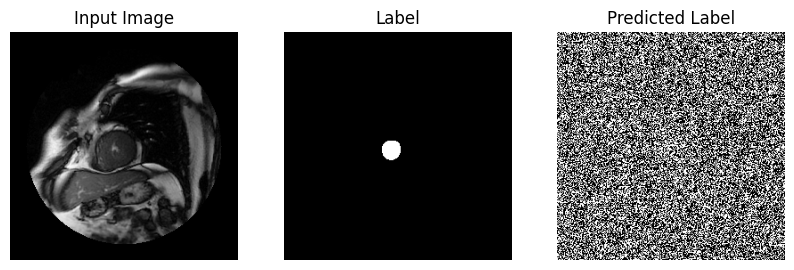


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.5367 - loss: 0.6931 - val_accuracy: 0.5491 - val_loss: 0.6931
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/steps


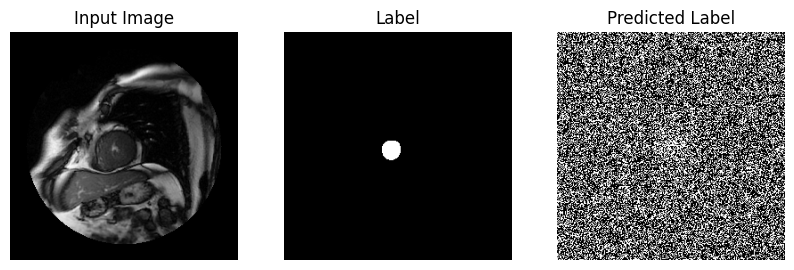


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.5704 - loss: 0.6931 - val_accuracy: 0.6003 - val_loss: 0.6931
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/steps


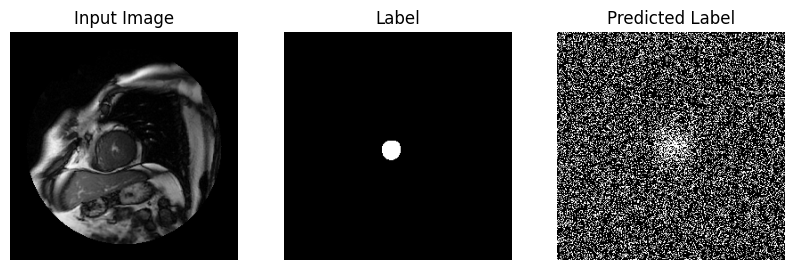


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.6553 - loss: 0.6931 - val_accuracy: 0.7302 - val_loss: 0.6931
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/steps


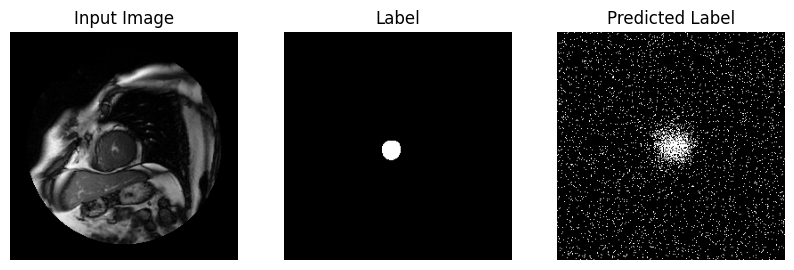


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.8351 - loss: 0.6931 - val_accuracy: 0.9387 - val_loss: 0.6931
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/steps


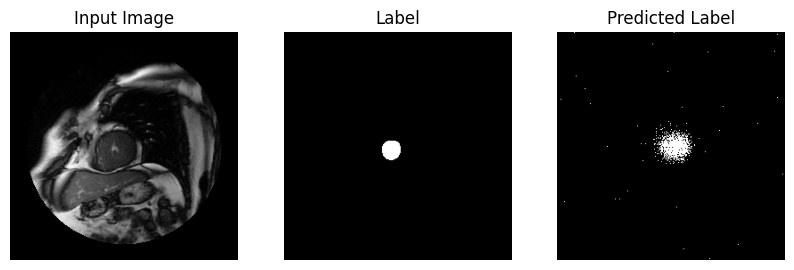


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9744 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/steps


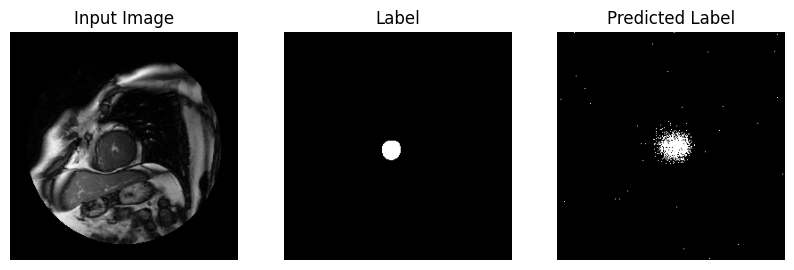


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/steps


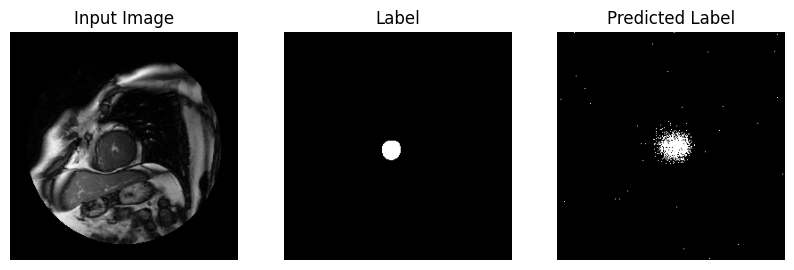


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/steps


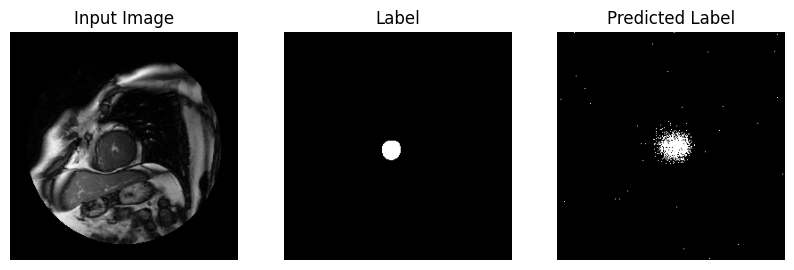


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/steps


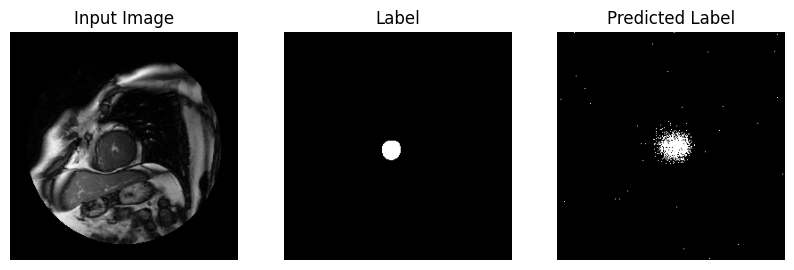


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/steps


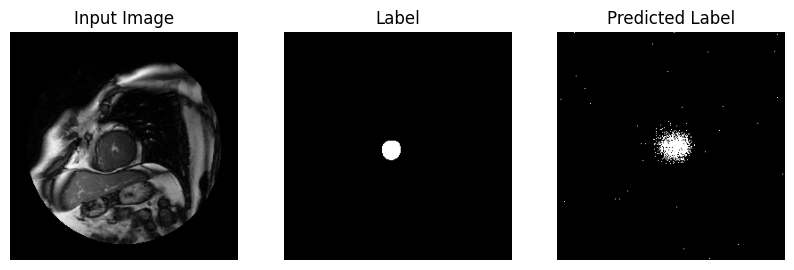


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/steps


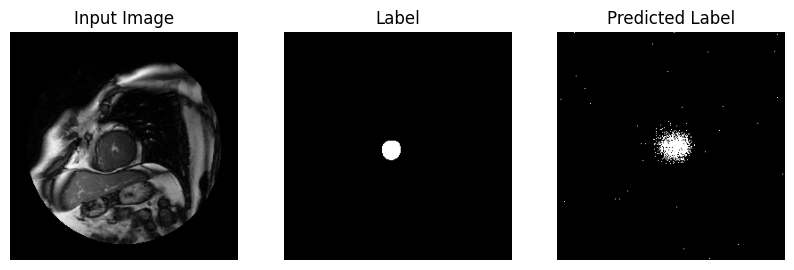


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/steps


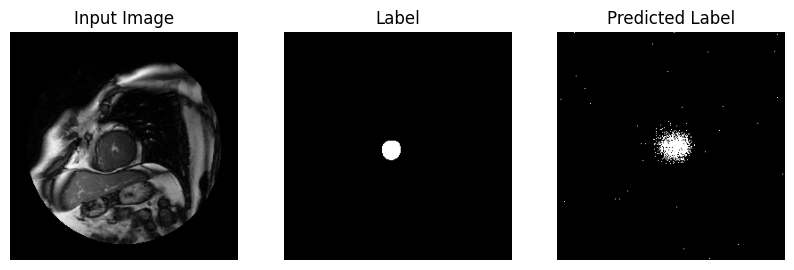


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/steps


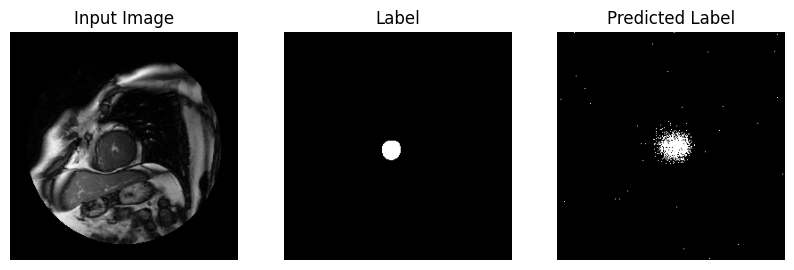


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/steps


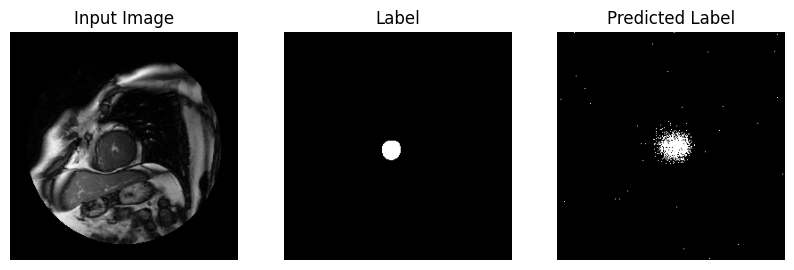


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/steps


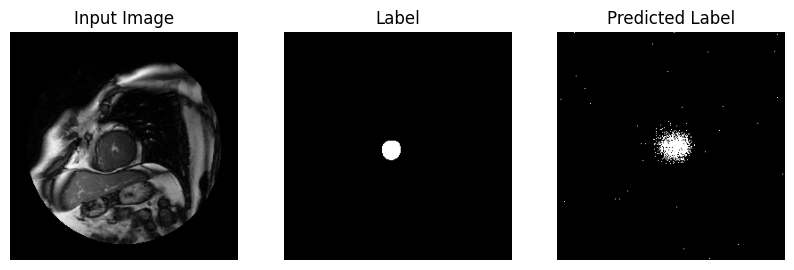


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/steps


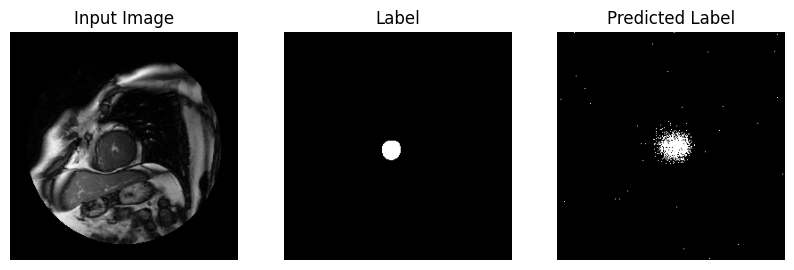


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/steps


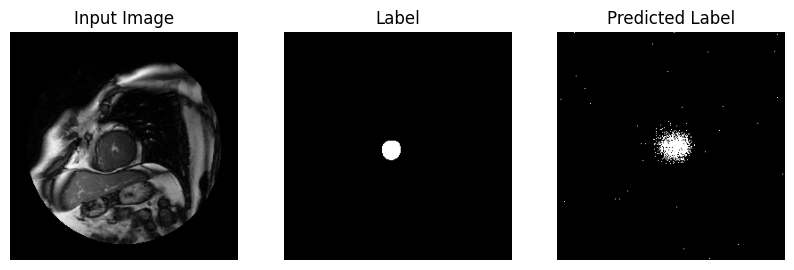


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/steps


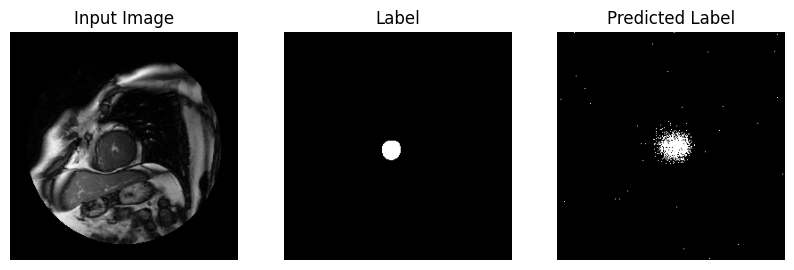


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9859 - loss: 0.6931 - val_accuracy: 0.9860 - val_loss: 0.6931


In [22]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

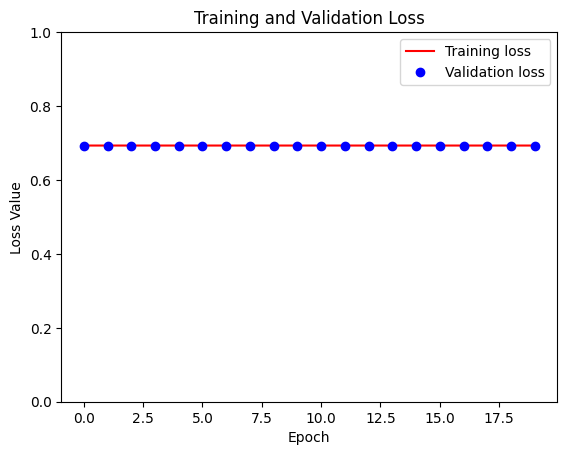

In [23]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [24]:
model.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9860 - loss: 0.6931


C:\Users\p\PycharmProjects\Image Segementation\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.6931402683258057, 0.9859942197799683]

In [25]:
%load_ext tensorboard

In [26]:
%tensorboard --logdir logs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


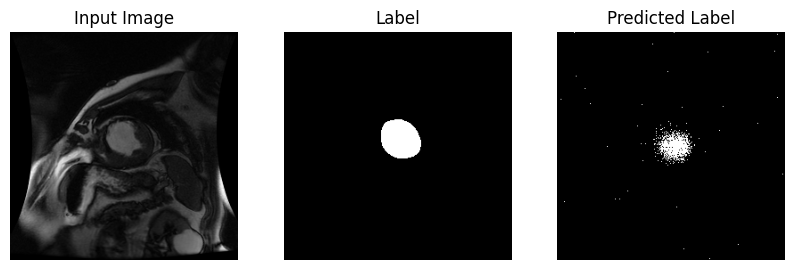

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


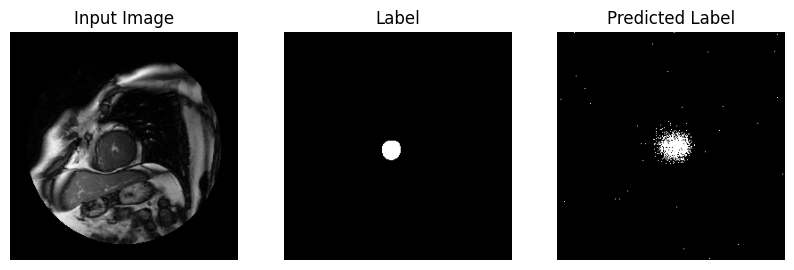

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


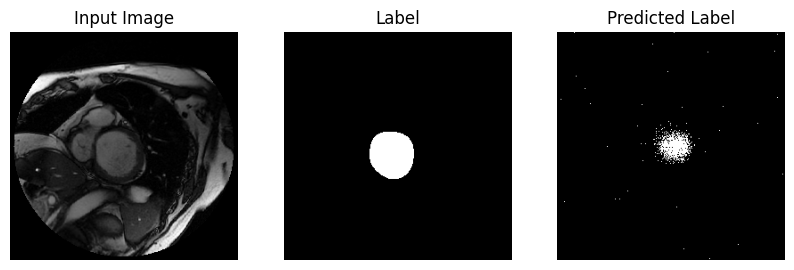

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


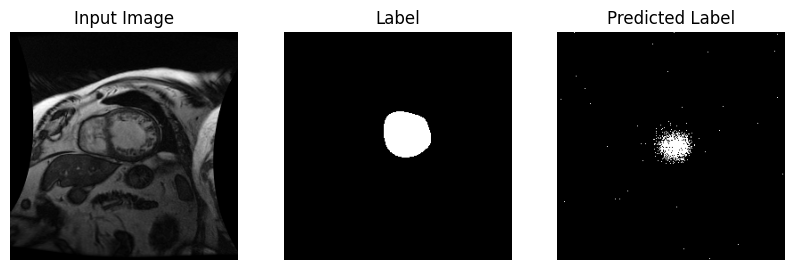

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


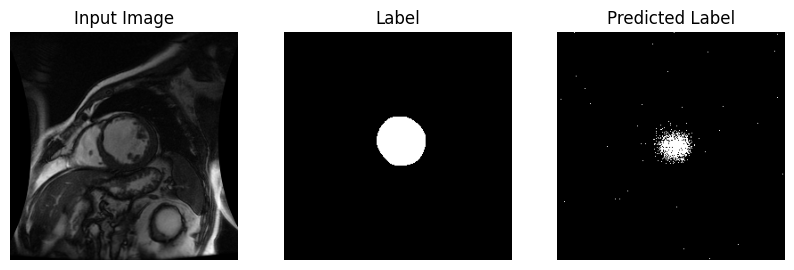

In [27]:
show_predictions(test_dataset, 5)

In [30]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

C:\Users\p\PycharmProjects\Image Segementation\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# print out the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 128, 128, 100)  │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 200)    │       500,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 300)    │       540,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 300)    │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 2)      │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 256, 2)    │         3,846 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857,848 (7.09 MB)

 Trainable params: 1,857,848 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


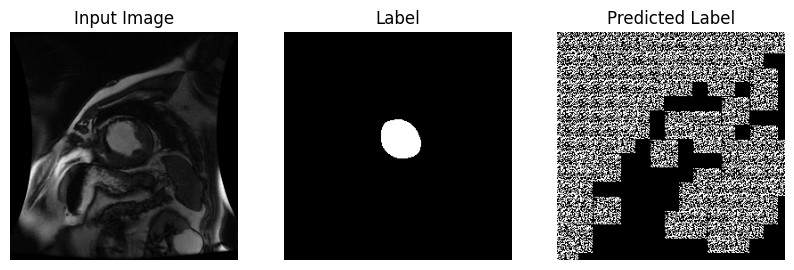

In [33]:
# show a predection, as an example
show_predictions(test_dataset)

In [34]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/steps


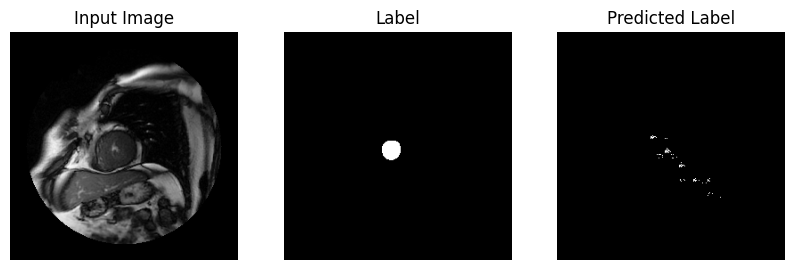


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9695 - loss: 0.1001 - val_accuracy: 0.9830 - val_loss: 0.0541
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/steps


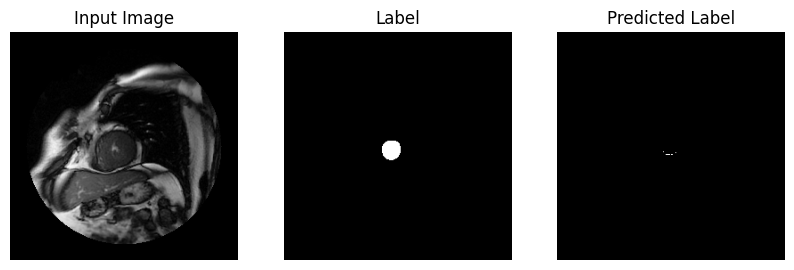


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9838 - loss: 0.0405 - val_accuracy: 0.9833 - val_loss: 0.0329
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/steps


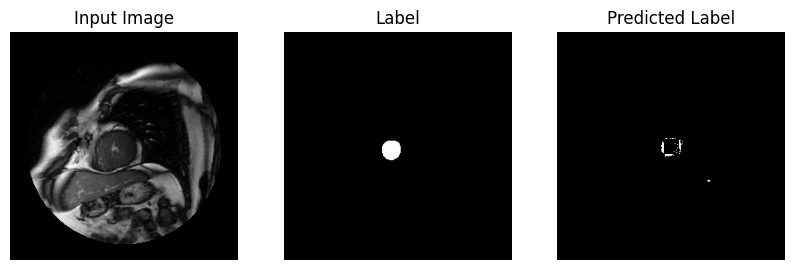


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9849 - loss: 0.0282 - val_accuracy: 0.9849 - val_loss: 0.0255
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/steps


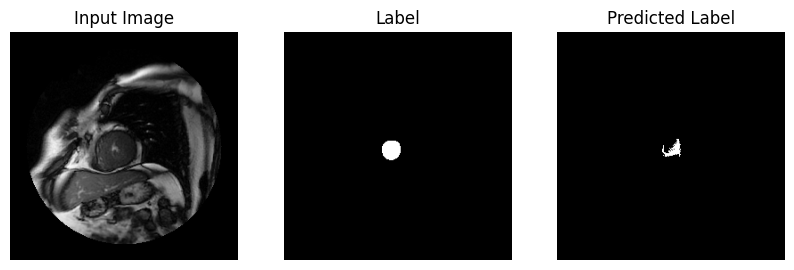


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9890 - loss: 0.0228 - val_accuracy: 0.9891 - val_loss: 0.0246
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/steps


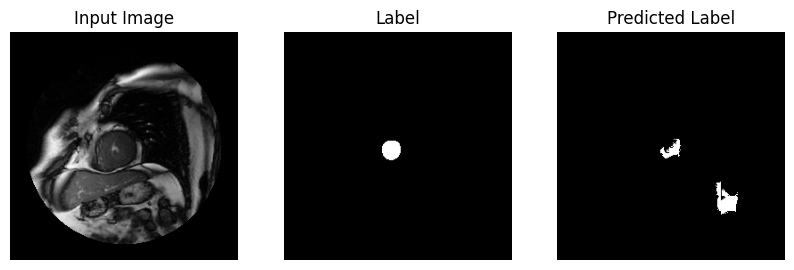


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9915 - loss: 0.0205 - val_accuracy: 0.9889 - val_loss: 0.0256
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/steps


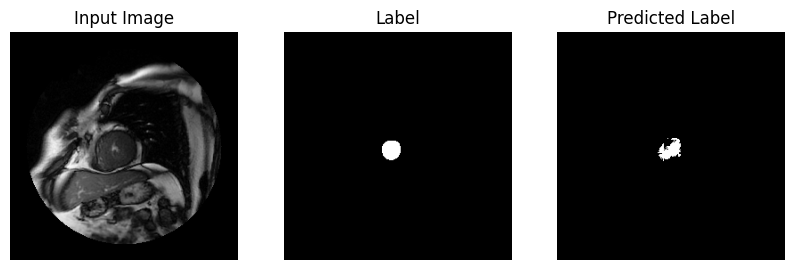


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9929 - loss: 0.0183 - val_accuracy: 0.9931 - val_loss: 0.0188
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/steps


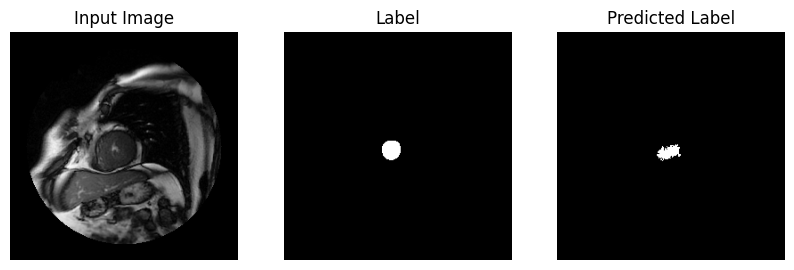


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9942 - loss: 0.0158 - val_accuracy: 0.9932 - val_loss: 0.0170
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


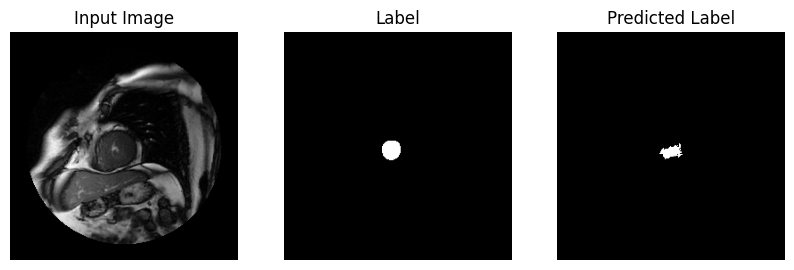


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9950 - loss: 0.0140 - val_accuracy: 0.9931 - val_loss: 0.0184
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/steps


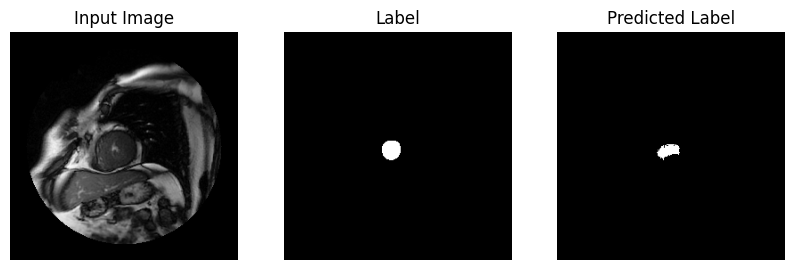


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9952 - loss: 0.0134 - val_accuracy: 0.9943 - val_loss: 0.0141
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/steps


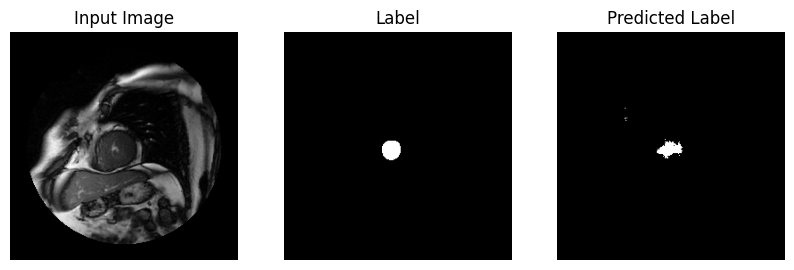


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9959 - loss: 0.0106 - val_accuracy: 0.9941 - val_loss: 0.0144
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/steps


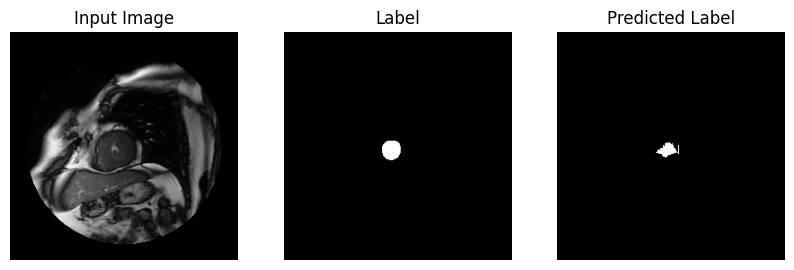


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9965 - loss: 0.0088 - val_accuracy: 0.9944 - val_loss: 0.0182
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/steps


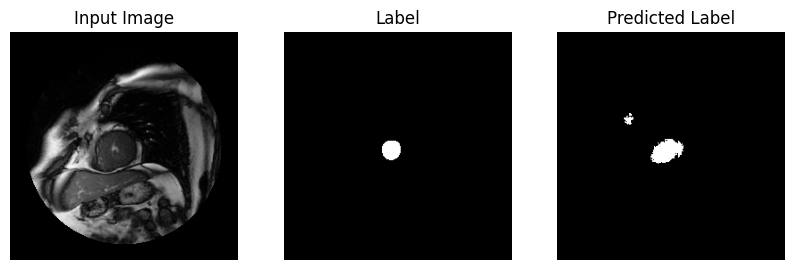


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9969 - loss: 0.0076 - val_accuracy: 0.9946 - val_loss: 0.0132
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


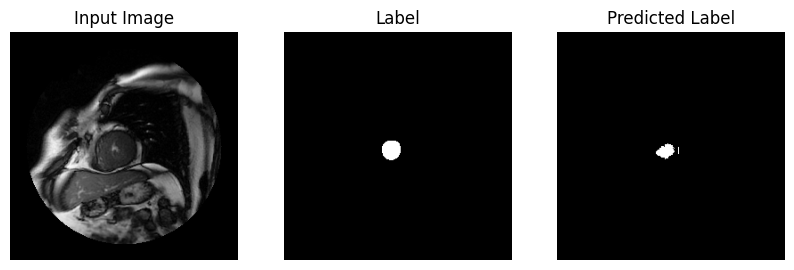


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9973 - loss: 0.0065 - val_accuracy: 0.9962 - val_loss: 0.0101
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/steps


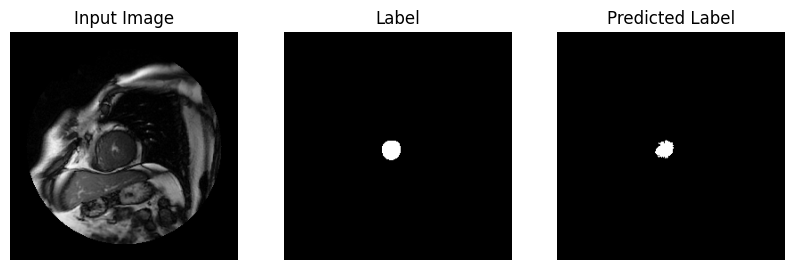


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9974 - loss: 0.0062 - val_accuracy: 0.9967 - val_loss: 0.0083
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/steps


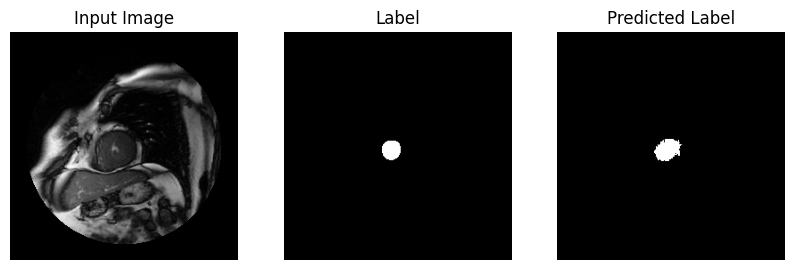


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9977 - loss: 0.0055 - val_accuracy: 0.9961 - val_loss: 0.0097
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/steps


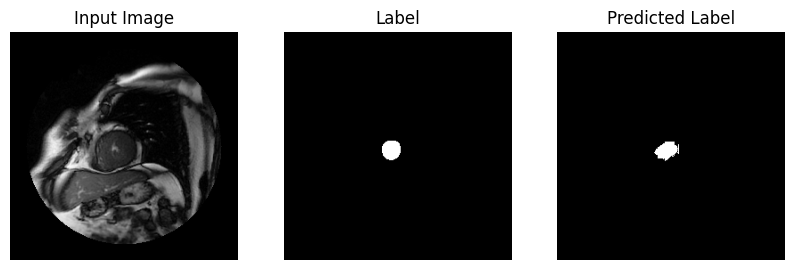


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9979 - loss: 0.0048 - val_accuracy: 0.9970 - val_loss: 0.0078
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


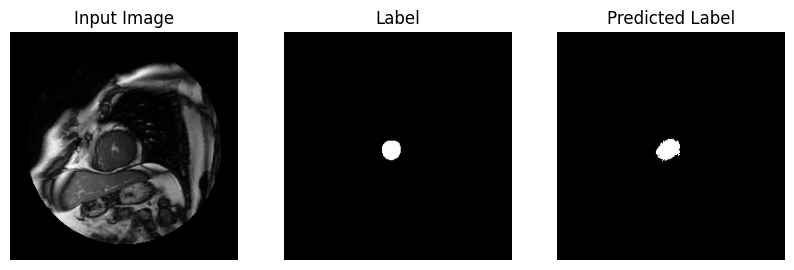


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9981 - loss: 0.0045 - val_accuracy: 0.9970 - val_loss: 0.0074
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/steps


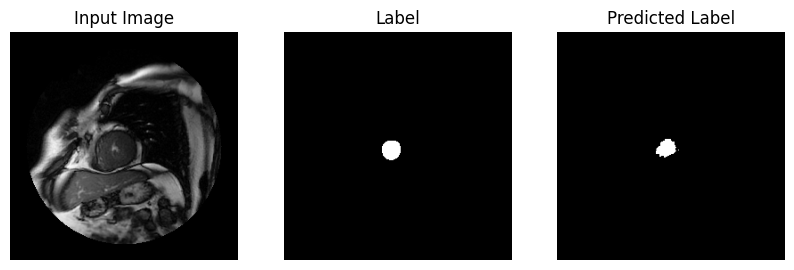


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9982 - loss: 0.0044 - val_accuracy: 0.9968 - val_loss: 0.0091
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/steps


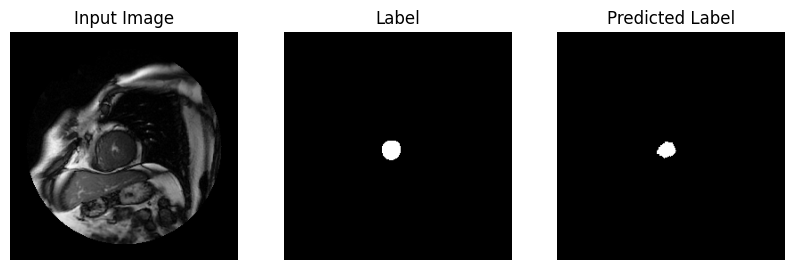


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9981 - loss: 0.0046 - val_accuracy: 0.9968 - val_loss: 0.0090
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/steps


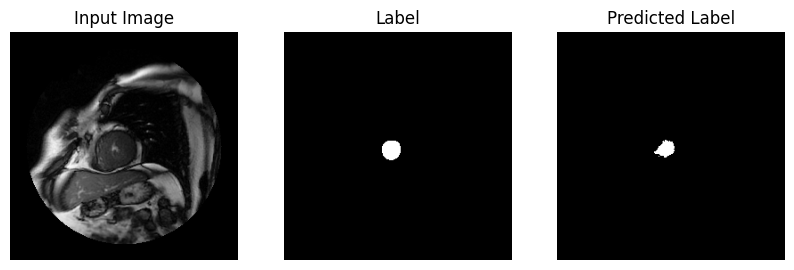


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9982 - loss: 0.0043 - val_accuracy: 0.9964 - val_loss: 0.0106


In [35]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

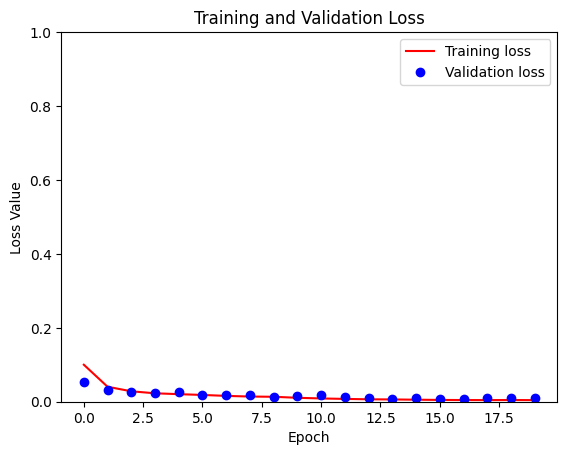

In [36]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [37]:
model.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.0106


[0.010618194006383419, 0.9964218139648438]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


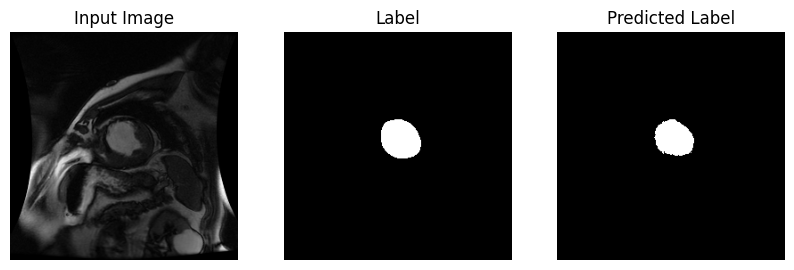

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


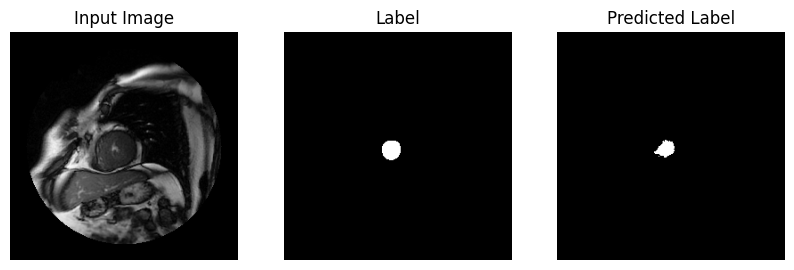

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


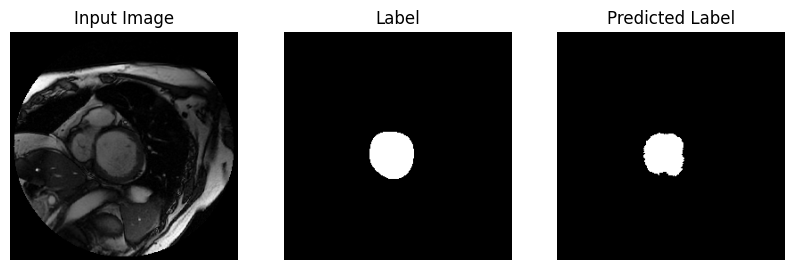

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


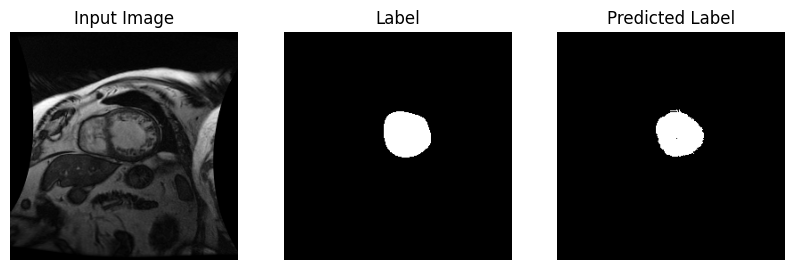

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


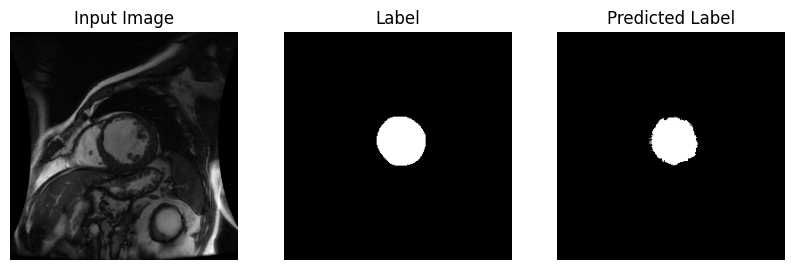

In [38]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)

In [55]:
def dice_coef(y_true, y_pred, smooth=1):
    # Convert predictions to class indices
    indices = K.argmax(y_pred, axis=3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    # Cast both to float32
    true_cast = K.cast(y_true, dtype='float32')
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

    return dice

In [56]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [57]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/steptep - accuracy: 0.9


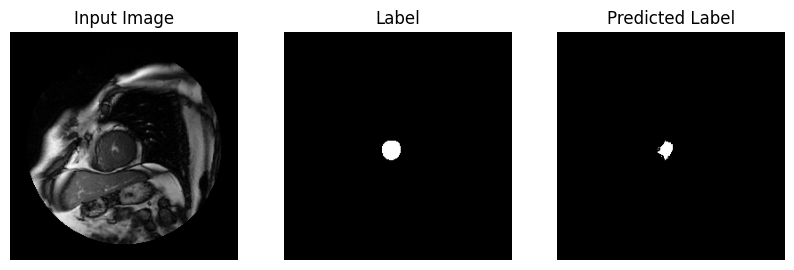


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.9981 - dice_coef: 0.9073 - loss: 0.0044 - val_accuracy: 0.9968 - val_dice_coef: 0.7680 - val_loss: 0.0089
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/steptep - accuracy: 0.99


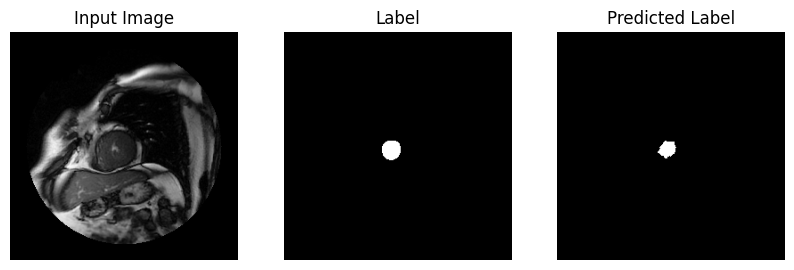


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9983 - dice_coef: 0.9137 - loss: 0.0041 - val_accuracy: 0.9971 - val_dice_coef: 0.7977 - val_loss: 0.0078
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/stepstep - accuracy: 0.99


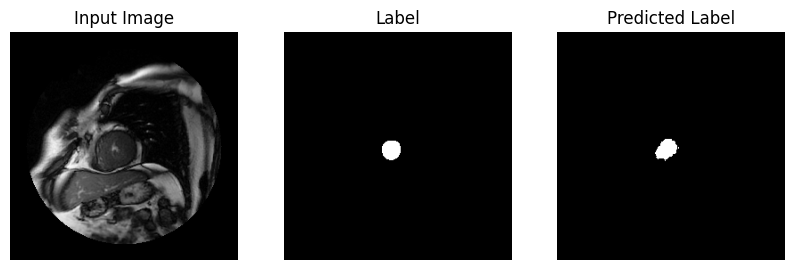


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9984 - dice_coef: 0.9181 - loss: 0.0037 - val_accuracy: 0.9970 - val_dice_coef: 0.8121 - val_loss: 0.0079
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/stepstep - accuracy: 0.99


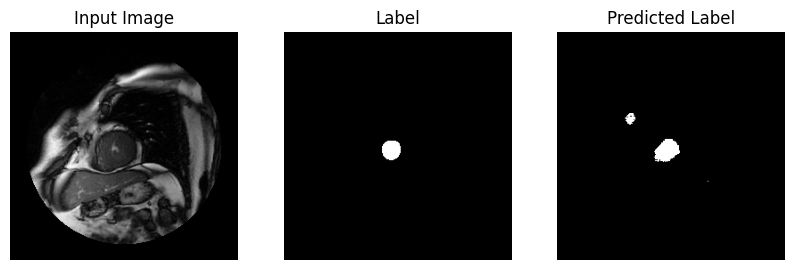


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9985 - dice_coef: 0.9196 - loss: 0.0036 - val_accuracy: 0.9967 - val_dice_coef: 0.8093 - val_loss: 0.0086
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/stepstep - accuracy: 0.99


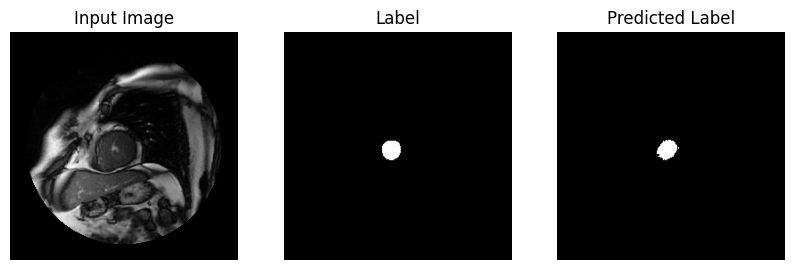


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9985 - dice_coef: 0.9243 - loss: 0.0035 - val_accuracy: 0.9972 - val_dice_coef: 0.8038 - val_loss: 0.0082
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/steptep - accuracy: 0.99


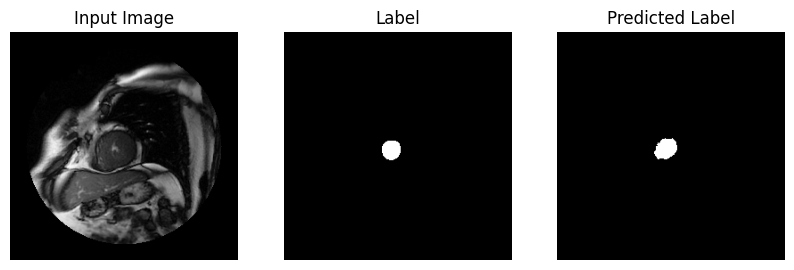


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9986 - dice_coef: 0.9337 - loss: 0.0032 - val_accuracy: 0.9973 - val_dice_coef: 0.8109 - val_loss: 0.0081
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - accuracy: 0.99


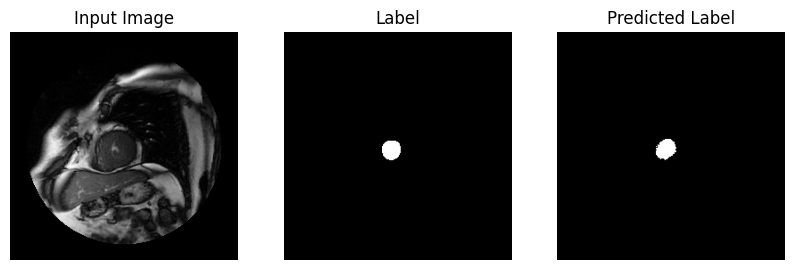


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9987 - dice_coef: 0.9351 - loss: 0.0031 - val_accuracy: 0.9972 - val_dice_coef: 0.7951 - val_loss: 0.0082
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/steptep - accuracy: 0.99


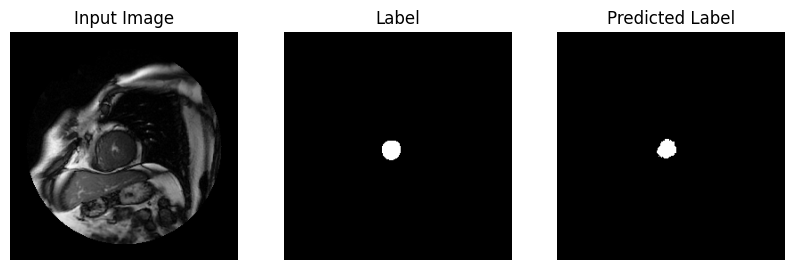


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9986 - dice_coef: 0.9232 - loss: 0.0034 - val_accuracy: 0.9970 - val_dice_coef: 0.7993 - val_loss: 0.0086
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepstep - accuracy: 0.99


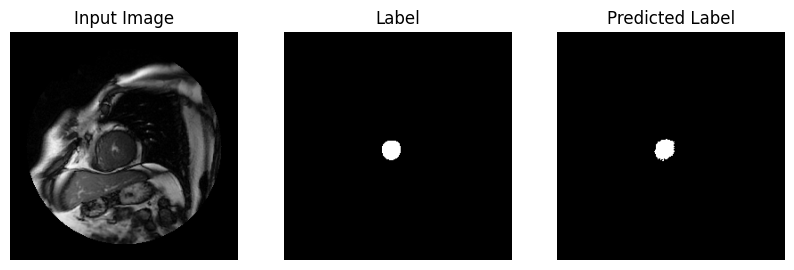


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9986 - dice_coef: 0.9347 - loss: 0.0032 - val_accuracy: 0.9969 - val_dice_coef: 0.7929 - val_loss: 0.0088
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/steptep - accuracy: 0.9


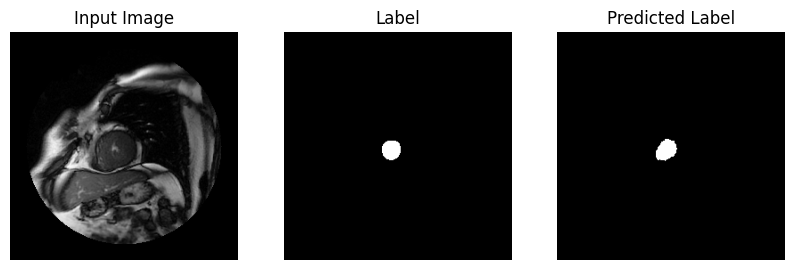


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9988 - dice_coef: 0.9382 - loss: 0.0029 - val_accuracy: 0.9972 - val_dice_coef: 0.8269 - val_loss: 0.0080
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepstep - accuracy: 0.99


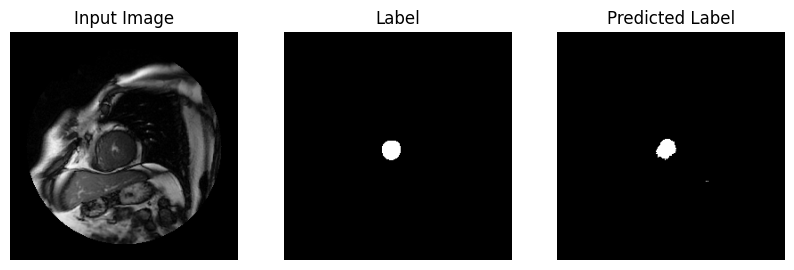


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9987 - dice_coef: 0.9375 - loss: 0.0029 - val_accuracy: 0.9973 - val_dice_coef: 0.8056 - val_loss: 0.0086
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/stepstep - accuracy: 0.99


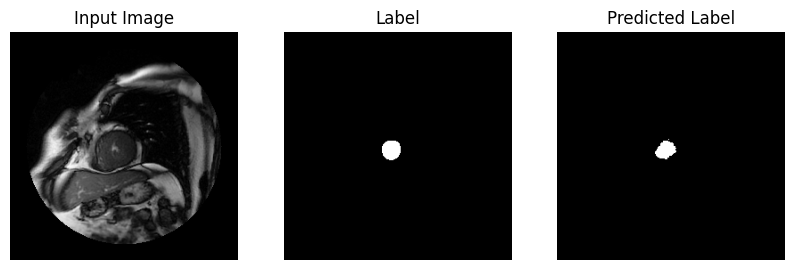


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9988 - dice_coef: 0.9402 - loss: 0.0028 - val_accuracy: 0.9973 - val_dice_coef: 0.8073 - val_loss: 0.0096
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/stepstep - accuracy: 0.99


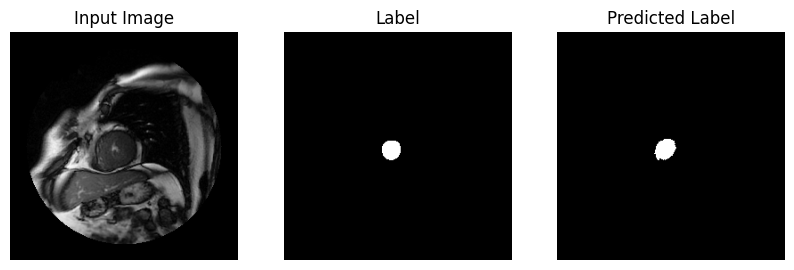


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9988 - dice_coef: 0.9410 - loss: 0.0028 - val_accuracy: 0.9973 - val_dice_coef: 0.8118 - val_loss: 0.0086
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/stepstep - accuracy: 0.99


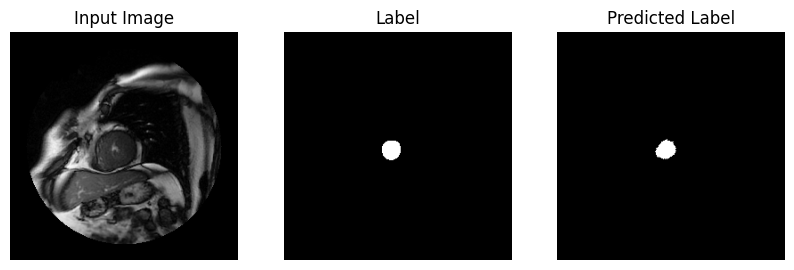


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9989 - dice_coef: 0.9461 - loss: 0.0026 - val_accuracy: 0.9975 - val_dice_coef: 0.8197 - val_loss: 0.0085
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/stepstep - accuracy: 0.99


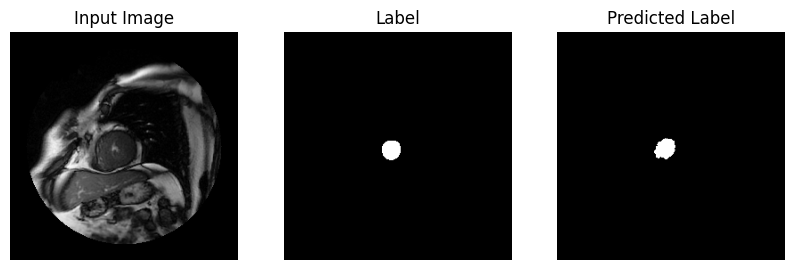


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9988 - dice_coef: 0.9381 - loss: 0.0028 - val_accuracy: 0.9972 - val_dice_coef: 0.8193 - val_loss: 0.0091
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/stepstep - accuracy: 0.99


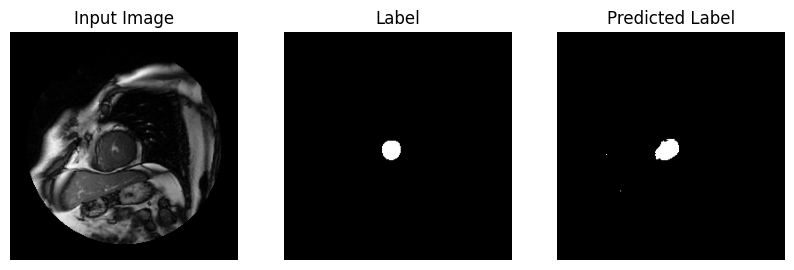


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9972 - dice_coef: 0.8662 - loss: 0.0094 - val_accuracy: 0.9969 - val_dice_coef: 0.8022 - val_loss: 0.0082
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepstep - accuracy: 0.99


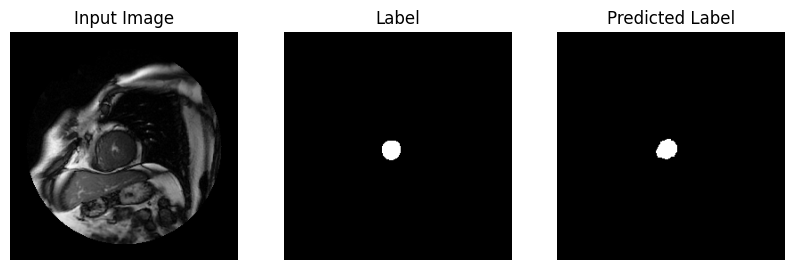


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9987 - dice_coef: 0.9340 - loss: 0.0031 - val_accuracy: 0.9974 - val_dice_coef: 0.8272 - val_loss: 0.0074
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/stepstep - accuracy: 0.99


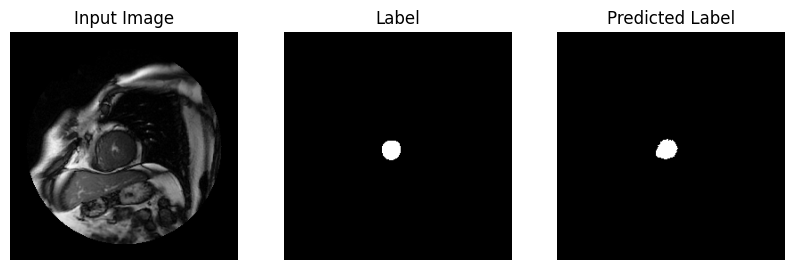


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9990 - dice_coef: 0.9463 - loss: 0.0024 - val_accuracy: 0.9975 - val_dice_coef: 0.8110 - val_loss: 0.0080
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/stepstep - accuracy: 0.99


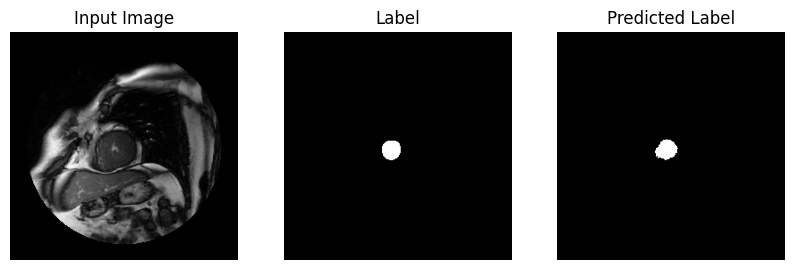


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9991 - dice_coef: 0.9551 - loss: 0.0020 - val_accuracy: 0.9973 - val_dice_coef: 0.8045 - val_loss: 0.0094
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/stepstep - accuracy: 0.99


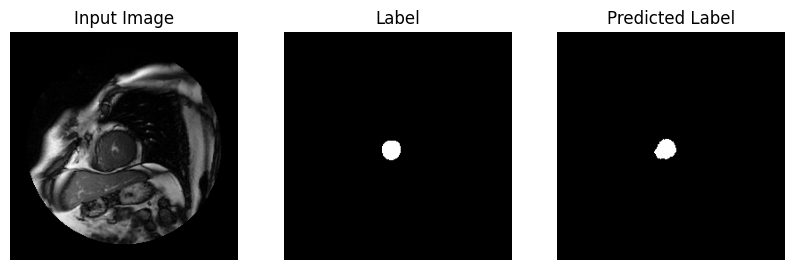


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9992 - dice_coef: 0.9569 - loss: 0.0020 - val_accuracy: 0.9974 - val_dice_coef: 0.8111 - val_loss: 0.0103
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/stepstep - accuracy: 0.99


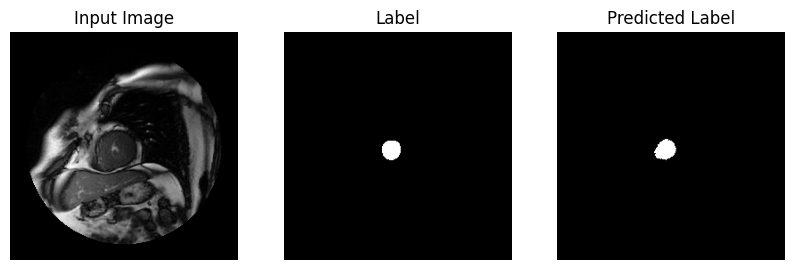


Sample Prediction after epoch 21

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9563 - loss: 0.0020 - val_accuracy: 0.9974 - val_dice_coef: 0.8050 - val_loss: 0.0099
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepstep - accuracy: 0.99


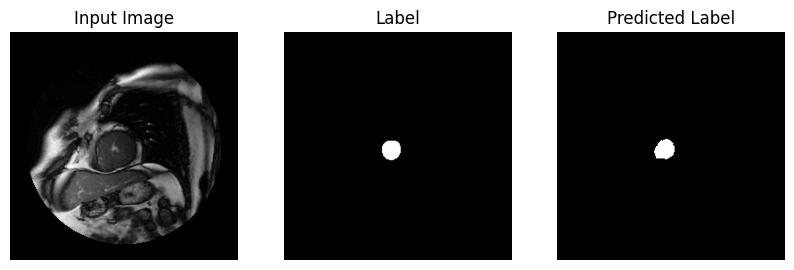


Sample Prediction after epoch 22

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9555 - loss: 0.0020 - val_accuracy: 0.9973 - val_dice_coef: 0.8041 - val_loss: 0.0111
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/stepstep - accuracy: 0.99


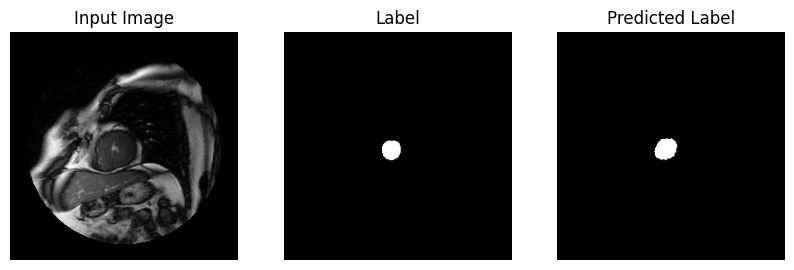


Sample Prediction after epoch 23

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9534 - loss: 0.0020 - val_accuracy: 0.9973 - val_dice_coef: 0.8085 - val_loss: 0.0099
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.99


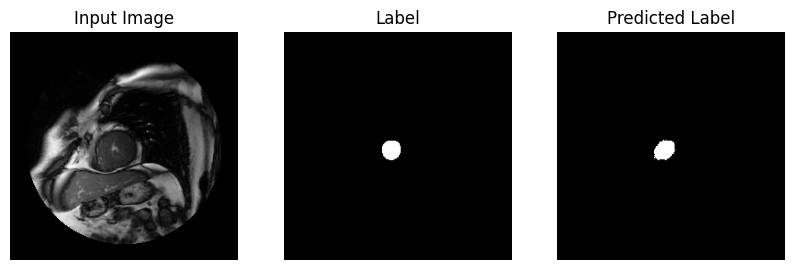


Sample Prediction after epoch 24

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9990 - dice_coef: 0.9449 - loss: 0.0024 - val_accuracy: 0.9973 - val_dice_coef: 0.8129 - val_loss: 0.0090
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/stepstep - accuracy: 0.99


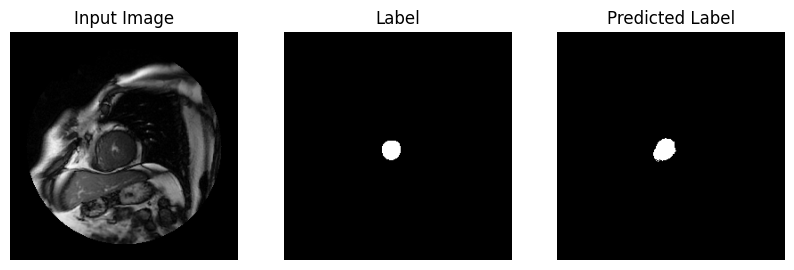


Sample Prediction after epoch 25

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9990 - dice_coef: 0.9476 - loss: 0.0024 - val_accuracy: 0.9972 - val_dice_coef: 0.8056 - val_loss: 0.0096
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/stepstep - accuracy: 0.99


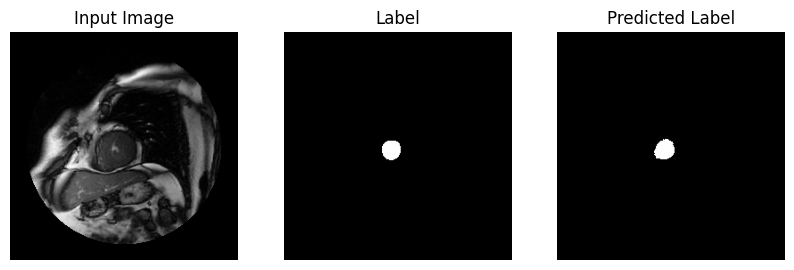


Sample Prediction after epoch 26

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9990 - dice_coef: 0.9509 - loss: 0.0023 - val_accuracy: 0.9976 - val_dice_coef: 0.8149 - val_loss: 0.0088
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.99


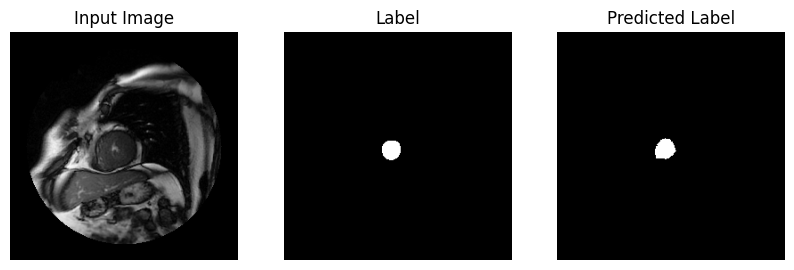


Sample Prediction after epoch 27

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9990 - dice_coef: 0.9523 - loss: 0.0022 - val_accuracy: 0.9974 - val_dice_coef: 0.8112 - val_loss: 0.0092
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/stepstep - accuracy: 0.99


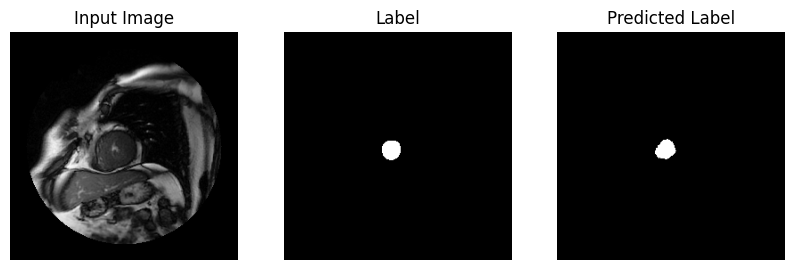


Sample Prediction after epoch 28

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9527 - loss: 0.0022 - val_accuracy: 0.9973 - val_dice_coef: 0.8061 - val_loss: 0.0111
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/stepstep - accuracy: 0.99


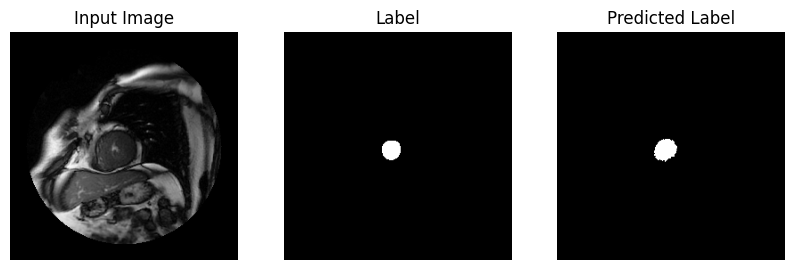


Sample Prediction after epoch 29

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9534 - loss: 0.0021 - val_accuracy: 0.9973 - val_dice_coef: 0.8093 - val_loss: 0.0090
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/steptep - accuracy: 0.9


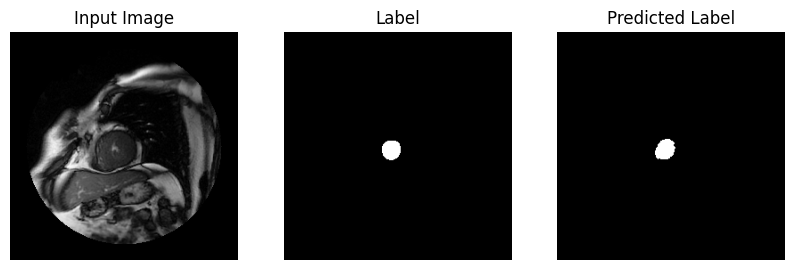


Sample Prediction after epoch 30

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9990 - dice_coef: 0.9487 - loss: 0.0023 - val_accuracy: 0.9974 - val_dice_coef: 0.8139 - val_loss: 0.0090


In [58]:
 # setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

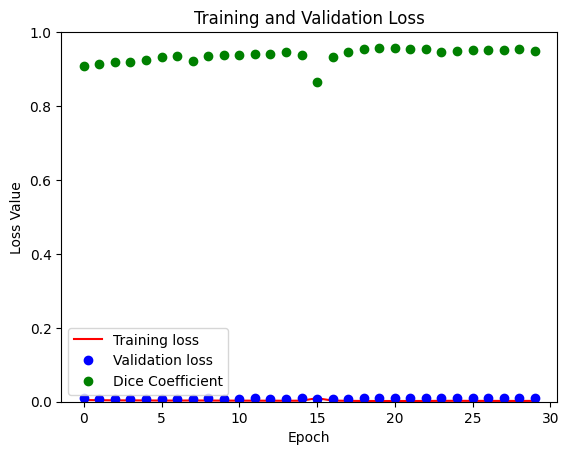

In [59]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [60]:
layers = layers  # Using the same as above. Try to beat us!

# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

tf.keras.backend.clear_session()
model = tf.keras.models.Sequential(layers)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef, 'accuracy'])

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/stepstep - accuracy: 0.99


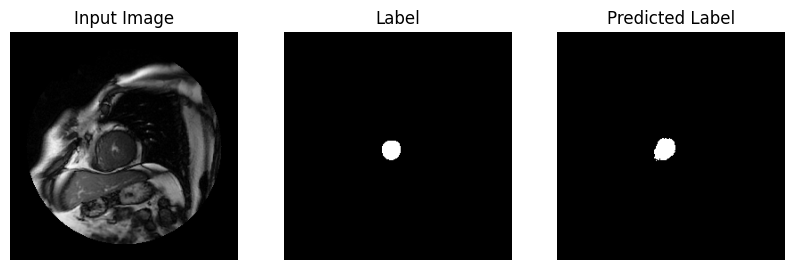


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9990 - dice_coef: 0.9490 - loss: 0.0024 - val_accuracy: 0.9974 - val_dice_coef: 0.8103 - val_loss: 0.0097
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


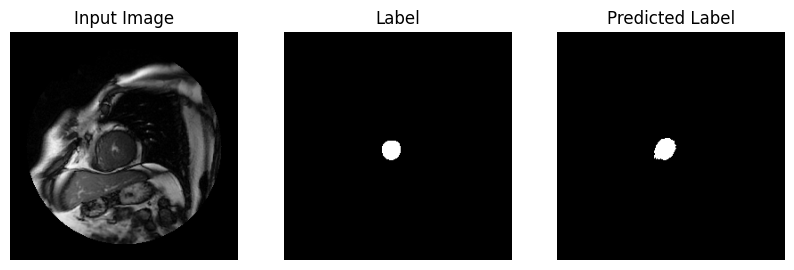


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9990 - dice_coef: 0.9504 - loss: 0.0023 - val_accuracy: 0.9974 - val_dice_coef: 0.8117 - val_loss: 0.0086
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepstep - accuracy: 0.99


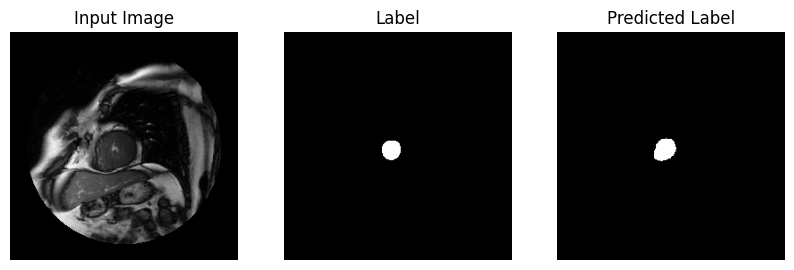


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9990 - dice_coef: 0.9512 - loss: 0.0023 - val_accuracy: 0.9973 - val_dice_coef: 0.8097 - val_loss: 0.0099
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


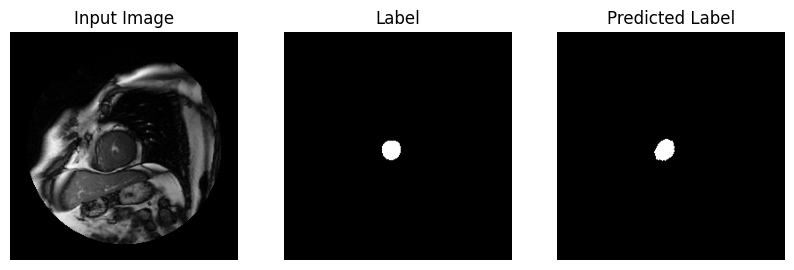


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9567 - loss: 0.0021 - val_accuracy: 0.9975 - val_dice_coef: 0.8145 - val_loss: 0.0091
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


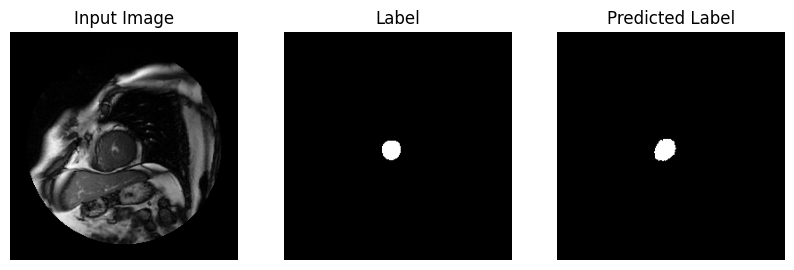


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9547 - loss: 0.0021 - val_accuracy: 0.9976 - val_dice_coef: 0.8178 - val_loss: 0.0088
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


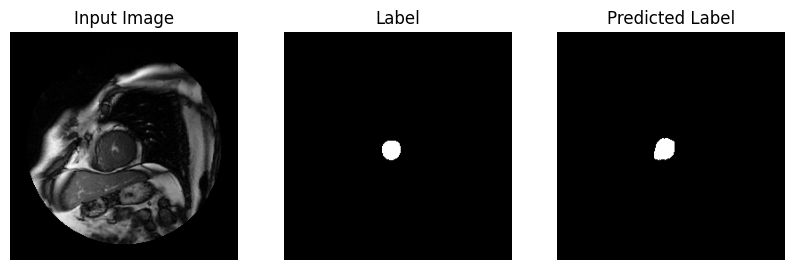


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9990 - dice_coef: 0.9486 - loss: 0.0024 - val_accuracy: 0.9975 - val_dice_coef: 0.8160 - val_loss: 0.0082
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/stepstep - accuracy: 0.99


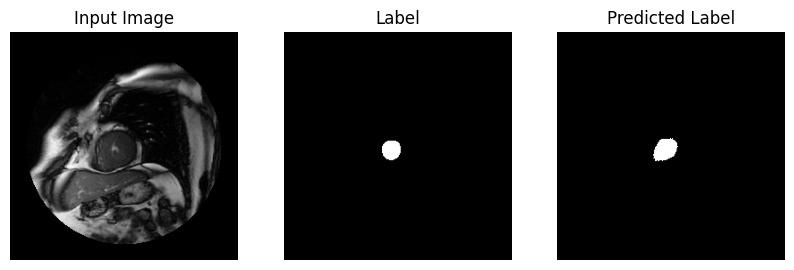


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9531 - loss: 0.0022 - val_accuracy: 0.9974 - val_dice_coef: 0.8130 - val_loss: 0.0094
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


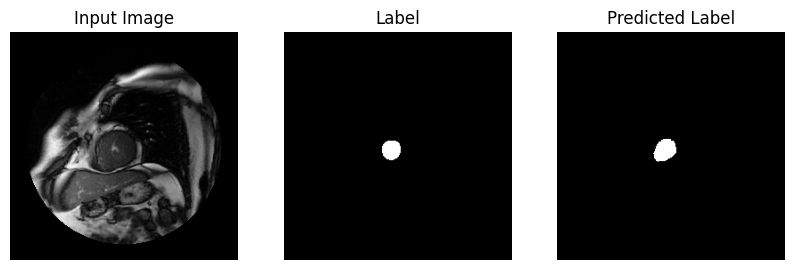


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9503 - loss: 0.0022 - val_accuracy: 0.9975 - val_dice_coef: 0.8124 - val_loss: 0.0097
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


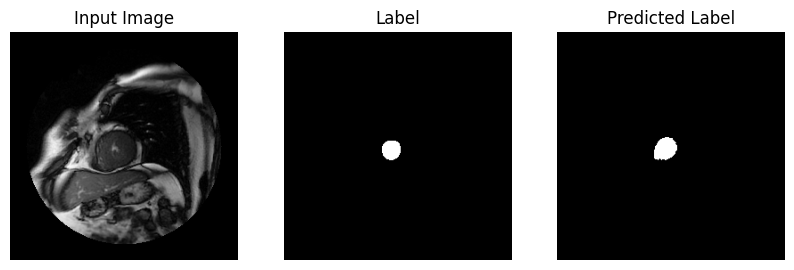


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9543 - loss: 0.0020 - val_accuracy: 0.9974 - val_dice_coef: 0.8124 - val_loss: 0.0096
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


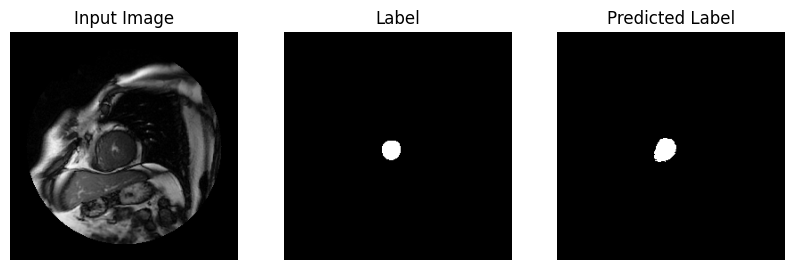


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9587 - loss: 0.0019 - val_accuracy: 0.9975 - val_dice_coef: 0.8129 - val_loss: 0.0099
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


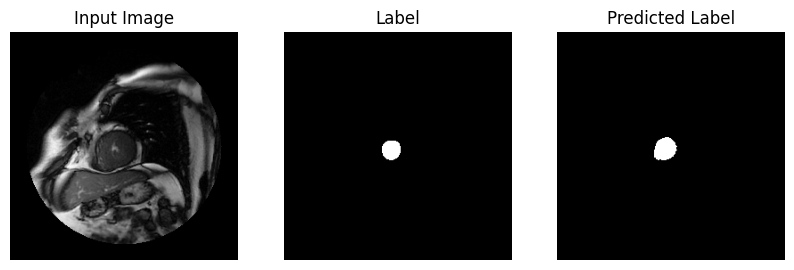


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9568 - loss: 0.0021 - val_accuracy: 0.9975 - val_dice_coef: 0.8149 - val_loss: 0.0098
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


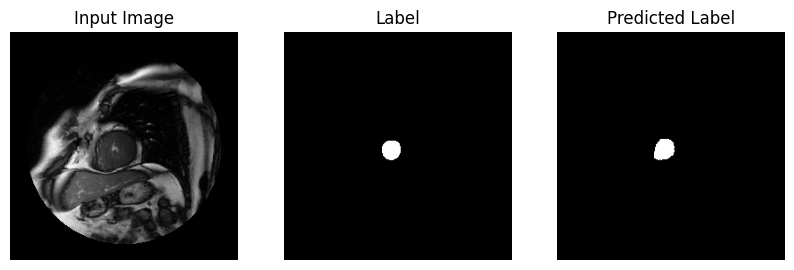


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9581 - loss: 0.0020 - val_accuracy: 0.9976 - val_dice_coef: 0.8184 - val_loss: 0.0097
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


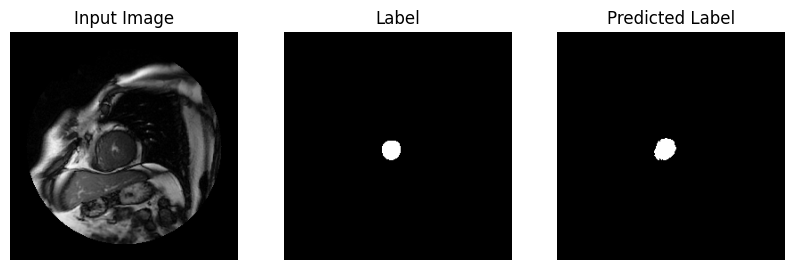


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9601 - loss: 0.0020 - val_accuracy: 0.9975 - val_dice_coef: 0.8132 - val_loss: 0.0095
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


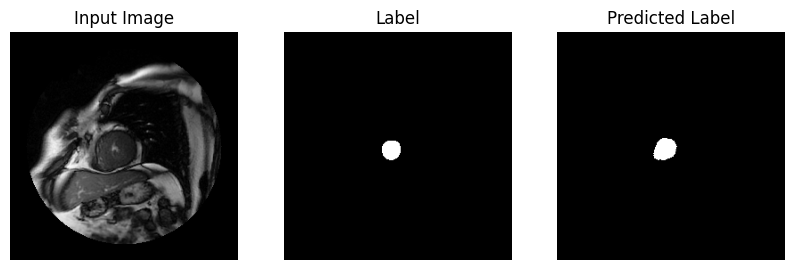


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9561 - loss: 0.0021 - val_accuracy: 0.9975 - val_dice_coef: 0.8146 - val_loss: 0.0111
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


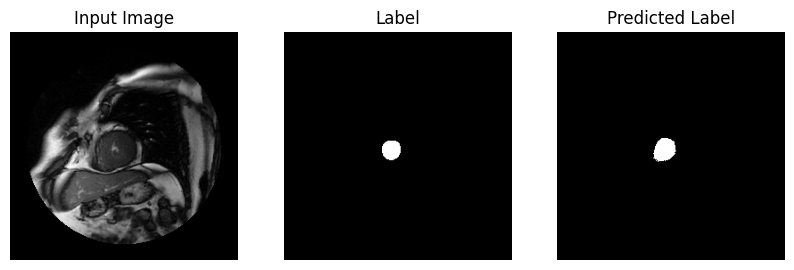


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9992 - dice_coef: 0.9549 - loss: 0.0019 - val_accuracy: 0.9975 - val_dice_coef: 0.8129 - val_loss: 0.0089
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


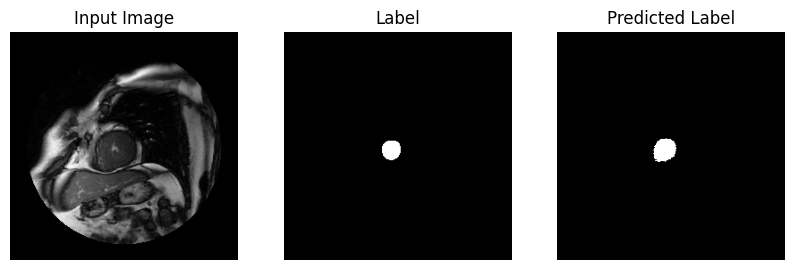


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9601 - loss: 0.0019 - val_accuracy: 0.9975 - val_dice_coef: 0.8146 - val_loss: 0.0096
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


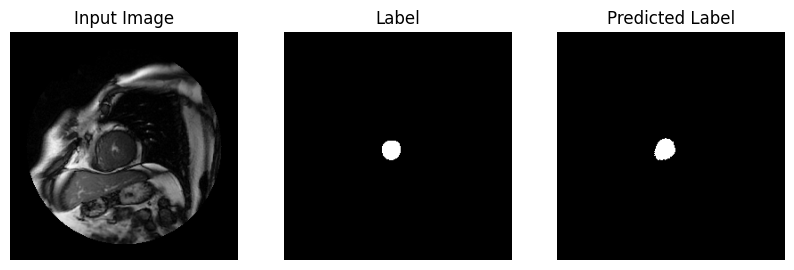


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9591 - loss: 0.0018 - val_accuracy: 0.9976 - val_dice_coef: 0.8200 - val_loss: 0.0100
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


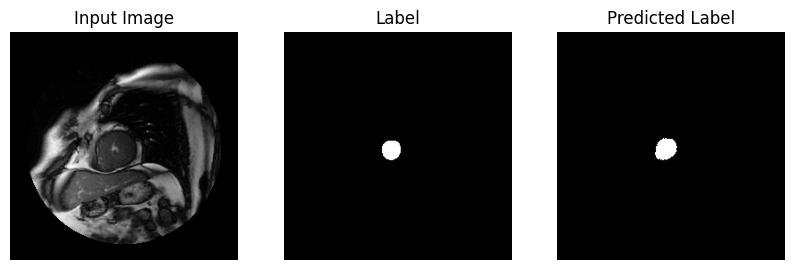


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9642 - loss: 0.0018 - val_accuracy: 0.9977 - val_dice_coef: 0.8200 - val_loss: 0.0097
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


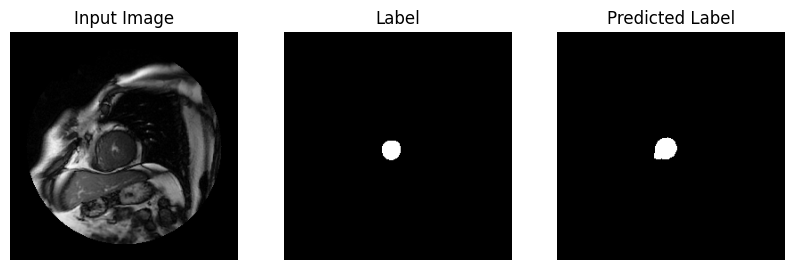


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9612 - loss: 0.0018 - val_accuracy: 0.9974 - val_dice_coef: 0.8094 - val_loss: 0.0116
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - accuracy: 0.99


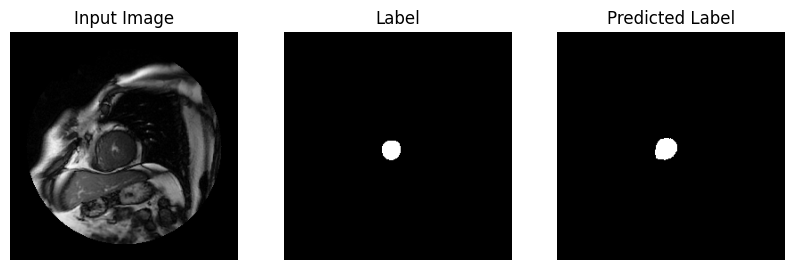


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9611 - loss: 0.0019 - val_accuracy: 0.9976 - val_dice_coef: 0.8196 - val_loss: 0.0112
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.99


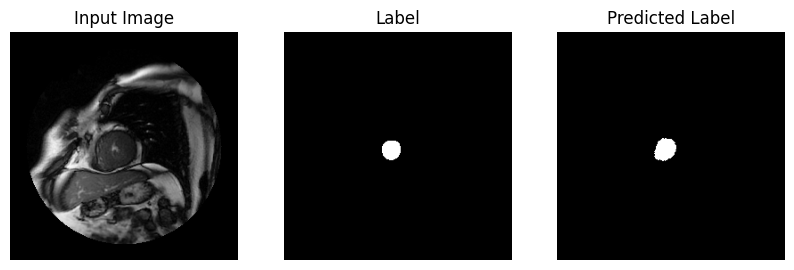


Sample Prediction after epoch 21

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9991 - dice_coef: 0.9586 - loss: 0.0020 - val_accuracy: 0.9975 - val_dice_coef: 0.8128 - val_loss: 0.0099
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.99


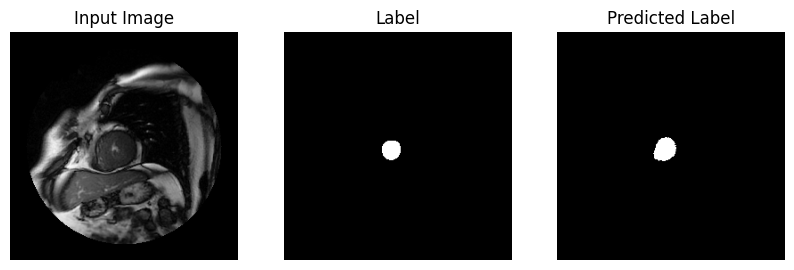


Sample Prediction after epoch 22

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9570 - loss: 0.0018 - val_accuracy: 0.9974 - val_dice_coef: 0.8128 - val_loss: 0.0107
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


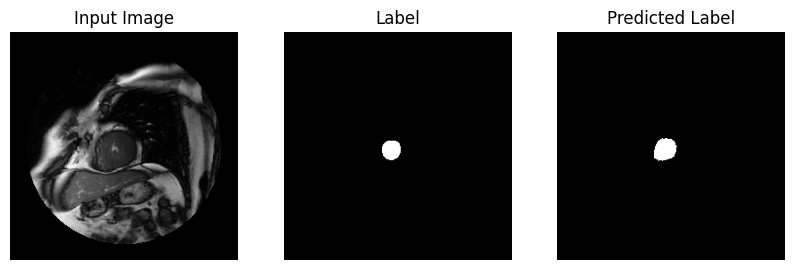


Sample Prediction after epoch 23

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9575 - loss: 0.0019 - val_accuracy: 0.9974 - val_dice_coef: 0.8113 - val_loss: 0.0103
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


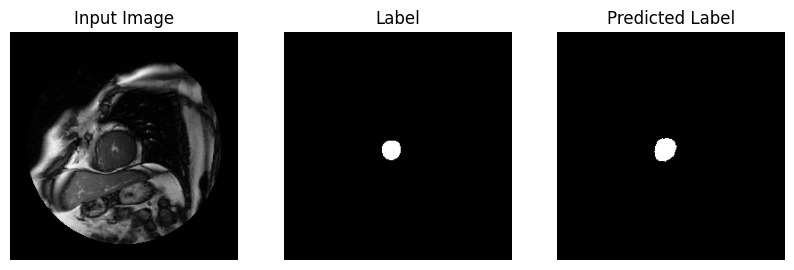


Sample Prediction after epoch 24

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9993 - dice_coef: 0.9605 - loss: 0.0017 - val_accuracy: 0.9975 - val_dice_coef: 0.8191 - val_loss: 0.0094
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepstep - accuracy: 0.99


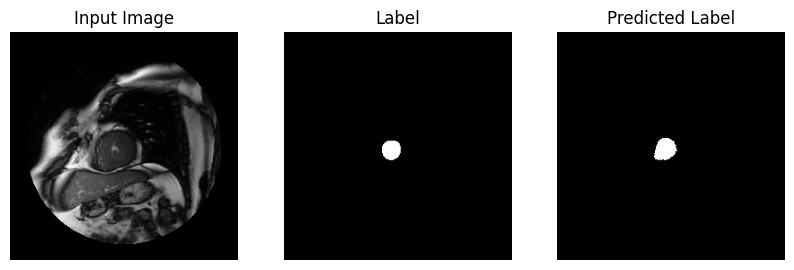


Sample Prediction after epoch 25

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9619 - loss: 0.0017 - val_accuracy: 0.9975 - val_dice_coef: 0.8130 - val_loss: 0.0102
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepstep - accuracy: 0.99


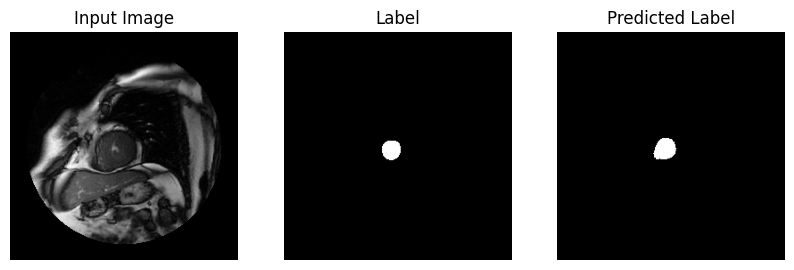


Sample Prediction after epoch 26

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9993 - dice_coef: 0.9655 - loss: 0.0017 - val_accuracy: 0.9975 - val_dice_coef: 0.8146 - val_loss: 0.0114
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepstep - accuracy: 0.99


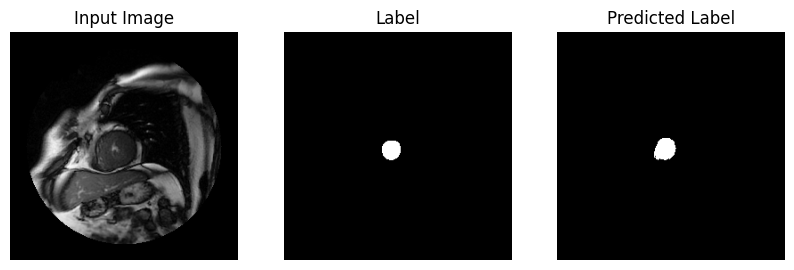


Sample Prediction after epoch 27

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9993 - dice_coef: 0.9639 - loss: 0.0017 - val_accuracy: 0.9975 - val_dice_coef: 0.8129 - val_loss: 0.0121
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


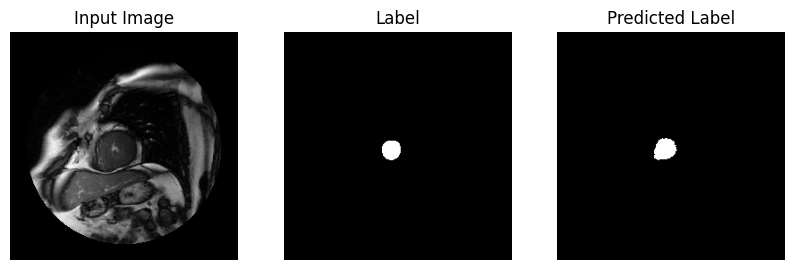


Sample Prediction after epoch 28

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9993 - dice_coef: 0.9637 - loss: 0.0017 - val_accuracy: 0.9975 - val_dice_coef: 0.8179 - val_loss: 0.0102
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepstep - accuracy: 0.99


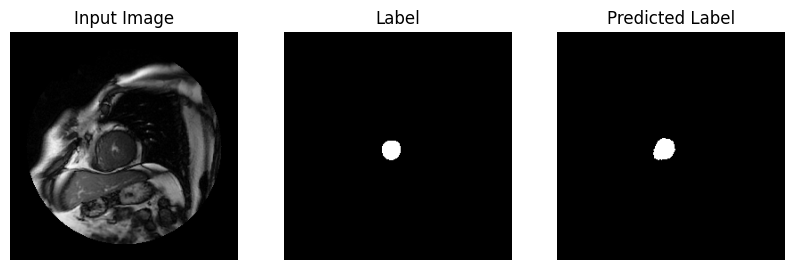


Sample Prediction after epoch 29

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9993 - dice_coef: 0.9623 - loss: 0.0017 - val_accuracy: 0.9975 - val_dice_coef: 0.8127 - val_loss: 0.0105
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/stepstep - accuracy: 0.99


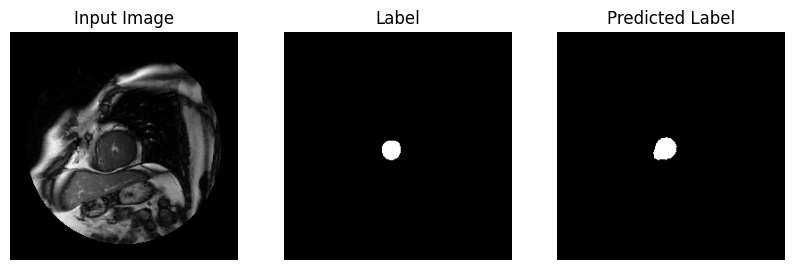


Sample Prediction after epoch 30

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9992 - dice_coef: 0.9607 - loss: 0.0018 - val_accuracy: 0.9975 - val_dice_coef: 0.8192 - val_loss: 0.0097


In [61]:
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])